## 🛍️ Customer Segmentation and Value Prediction in E-commerce
This notebook presents a comprehensive analysis of an e-commerce dataset spanning nearly one year of transactions. The objective is to extract meaningful insights from customer behavior and purchasing patterns to support strategic decision-making.

## 🔍 Key Goals:
Perform exploratory data analysis (EDA) on countries, products, and cancellations

Cluster product categories using K-Means and visualize them with PCA and WordClouds

Segment customers based on RFM (Recency, Frequency, Monetary) scores

Predict customer value using multiple regression models (Decision Tree, Gradient Boosting, etc.)

By the end of this analysis, we will have identified key customer groups and built models capable of forecasting their economic value — empowering data-driven marketing strategies and resource allocation. 🚀



## 1. Data Preparation & Library Setup

In this section, we import the essential Python libraries required for data analysis, visualization, machine learning, and interactive plotting. These libraries will allow us to process the data, create visual insights, and build predictive models.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, warnings
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, tree, ensemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
%matplotlib inline


## 🧾 2. Load Dataset & Define Columns

In this step, we define the column names based on the UCI e-commerce dataset 📦.  
Then we load the CSV file using proper encoding (`ISO-8859-1`) and assign our defined headers.  
Finally, we display the first few rows to understand the structure of the dataset. 👀


In [5]:
# Define column names (based on UCI e-commerce dataset)
columns = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
           'UnitPrice', 'CustomerID', 'Country']

# Load the data with proper encoding and headers
df = pd.read_csv("data.csv", encoding="ISO-8859-1", names=columns, header=1)

# Show basic structure
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
1,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
2,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
3,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom


In [6]:
df.tail(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541903,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541904,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541905,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541906,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


In [7]:
df.shape

(541908, 8)

In [8]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541908.000000,541908.000000,406828.000000
mean,9.552256,4.611117,15287.684272
std,218.081359,96.759942,1713.597701
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [9]:
# Check data types
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

## 🧹 3. Handle Missing Values & Clean Data

In this step, we check for missing values in the dataset 🔍.  
Rows with missing **`Description`** or **`CustomerID`** are removed to ensure data quality 🚫.  
After dropping, we reset the index to maintain a clean structure, and finally confirm the data types of each column. 🧪


In [11]:
# Check for missing values
print("Missing values before dropping:")
print(df.isnull().sum())

# Drop rows where 'Description' or 'CustomerID' is missing
df.dropna(subset=['Description', 'CustomerID'], inplace=True)

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

# Confirm data types
df.dtypes

Missing values before dropping:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [12]:
df.isnull().sum().sum()

0

In [13]:
# Convert 'InvoiceDate' to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [14]:
df['CustomerID'] = df['CustomerID'].astype(str)
print(df['CustomerID'].dtype)

object


## 🧹 4. Data Cleaning: Duplicates, Outliers, and Distribution Checks
In this phase, we perform comprehensive data cleaning to ensure quality and consistency across the dataset:

🔁 4.1 Remove Duplicates
We check for duplicated rows and remove them to prevent distorted analysis results.

🚩 4.2 Outlier Detection & Clipping
We analyze numerical columns (Quantity, UnitPrice, and TotalPrice) using the Interquartile Range (IQR) method.

Values beyond the acceptable range are clipped to minimize their influence on downstream analysis and modeling.

An outlier flag (Outlier_TotalPrice) is added for unusually high or low total prices.

📊 4.3 Outlier Distribution Visualization
Boxplots and histograms are used to visualize the spread of Quantity and UnitPrice, helping identify skewness and abnormal values.

🧼 4.4 IQR-Based Outlier Removal
A custom IQR function is used to completely remove extreme values in Quantity and UnitPrice.

The cleaned dataset is stored separately as df_cleaned for later use in modeling.

These cleaning steps ensure that the dataset is well-prepared for accurate customer segmentation and value prediction.

In [16]:
# Check and remove duplicate rows
duplicates = df.duplicated().sum()
print(f"Duplicated entries: {duplicates}")

if duplicates > 0:
    df.drop_duplicates(inplace=True)
    print("Duplicates removed.")


Duplicated entries: 5225
Duplicates removed.


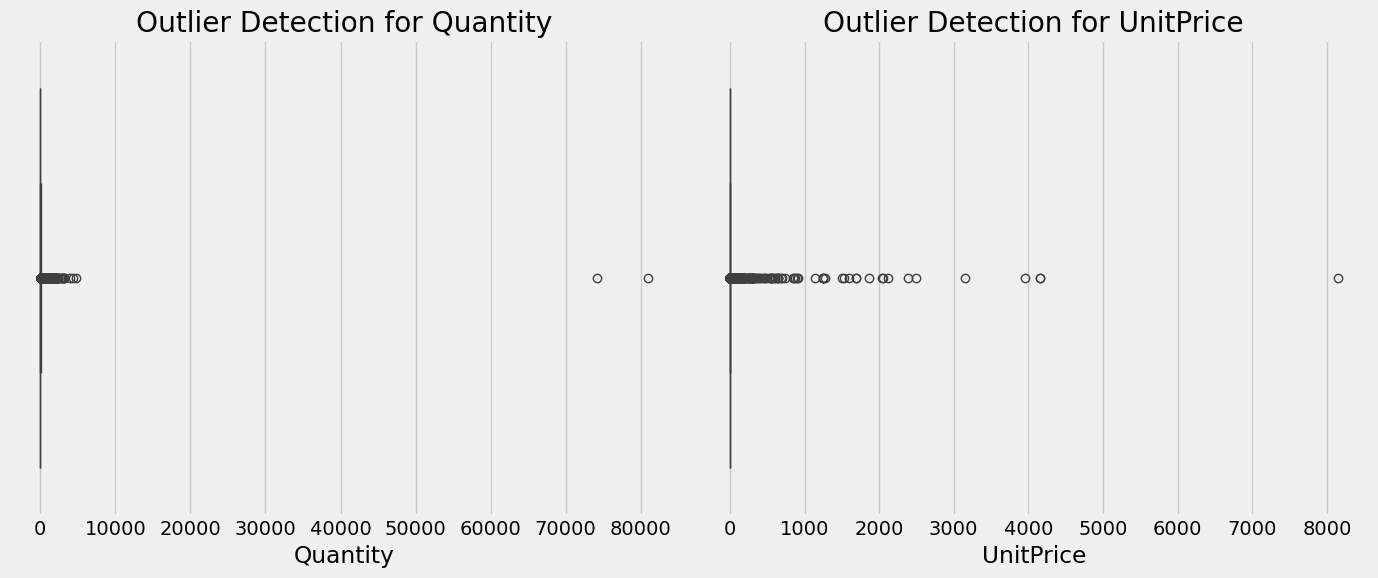

In [17]:
# Filter only positive values for outlier analysis
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Boxplot visualization
plt.figure(figsize=(14, 6))

# Quantity
plt.subplot(1, 2, 1)
sns.boxplot(x=df['Quantity'])
plt.title("Outlier Detection for Quantity")

# UnitPrice
plt.subplot(1, 2, 2)
sns.boxplot(x=df['UnitPrice'])
plt.title("Outlier Detection for UnitPrice")

plt.tight_layout()
plt.show()


In [18]:
# Choose the dataframe you want to analyze
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Remove 'CustomerID' from numeric columns for outlier analysis
numeric_cols = [col for col in numeric_cols if col != 'CustomerID']

# Loop through numeric columns and analyze outliers
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_ratio = len(outliers) / len(df) * 100

    print(f"\n📊 Column: {col}")
    print(f"Outliers Detected: {len(outliers)} ({outlier_ratio:.2f}%)")
    print(f"Lower Bound: {lower:.2f}, Upper Bound: {upper:.2f}")



📊 Column: Quantity
Outliers Detected: 25616 (6.52%)
Lower Bound: -13.00, Upper Bound: 27.00

📊 Column: UnitPrice
Outliers Detected: 34112 (8.69%)
Lower Bound: -2.50, Upper Bound: 7.50


In [19]:
# Calculate total price for each transaction
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Display the first few rows of Quantity, UnitPrice, and calculated TotalPrice
df[['Quantity', 'UnitPrice', 'TotalPrice']].head()


,Quantity,UnitPrice,TotalPrice
0,6,3.39,20.34
1,8,2.75,22.00
2,6,3.39,20.34
3,6,3.39,20.34
4,2,7.65,15.30


In [20]:
# Calculate IQR and apply clipping for Quantity
Q1 = df['Quantity'].quantile(0.25)
Q3 = df['Quantity'].quantile(0.75)
IQR = Q3 - Q1
df['Quantity'] = df['Quantity'].clip(lower=Q1 - 1.5 * IQR, upper=Q3 + 1.5 * IQR)

# Calculate IQR and apply clipping for UnitPrice
Q1 = df['UnitPrice'].quantile(0.25)
Q3 = df['UnitPrice'].quantile(0.75)
IQR = Q3 - Q1
df['UnitPrice'] = df['UnitPrice'].clip(lower=Q1 - 1.5 * IQR, upper=Q3 + 1.5 * IQR)

# Recalculate TotalPrice based on cleaned Quantity and UnitPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Calculate IQR and apply clipping for TotalPrice
Q1 = df['TotalPrice'].quantile(0.25)
Q3 = df['TotalPrice'].quantile(0.75)
IQR = Q3 - Q1
df['TotalPrice'] = df['TotalPrice'].clip(lower=Q1 - 1.5 * IQR, upper=Q3 + 1.5 * IQR)

In [21]:
df['Outlier_TotalPrice'] = (df['TotalPrice'] < -19.07) | (df['TotalPrice'] > 43.12)

In [22]:
# Choose the dataframe you want to analyze
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Remove 'CustomerID' from numeric columns for outlier analysis
numeric_cols = [col for col in numeric_cols if col != 'CustomerID']

# Loop through numeric columns and analyze outliers
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_ratio = len(outliers) / len(df) * 100

    print(f"\n📊 Column: {col}")
    print(f"Outliers Detected: {len(outliers)} ({outlier_ratio:.2f}%)")
    print(f"Lower Bound: {lower:.2f}, Upper Bound: {upper:.2f}")



📊 Column: Quantity
Outliers Detected: 0 (0.00%)
Lower Bound: -13.00, Upper Bound: 27.00

📊 Column: UnitPrice
Outliers Detected: 0 (0.00%)
Lower Bound: -2.50, Upper Bound: 7.50

📊 Column: TotalPrice
Outliers Detected: 0 (0.00%)
Lower Bound: -14.18, Upper Bound: 36.83


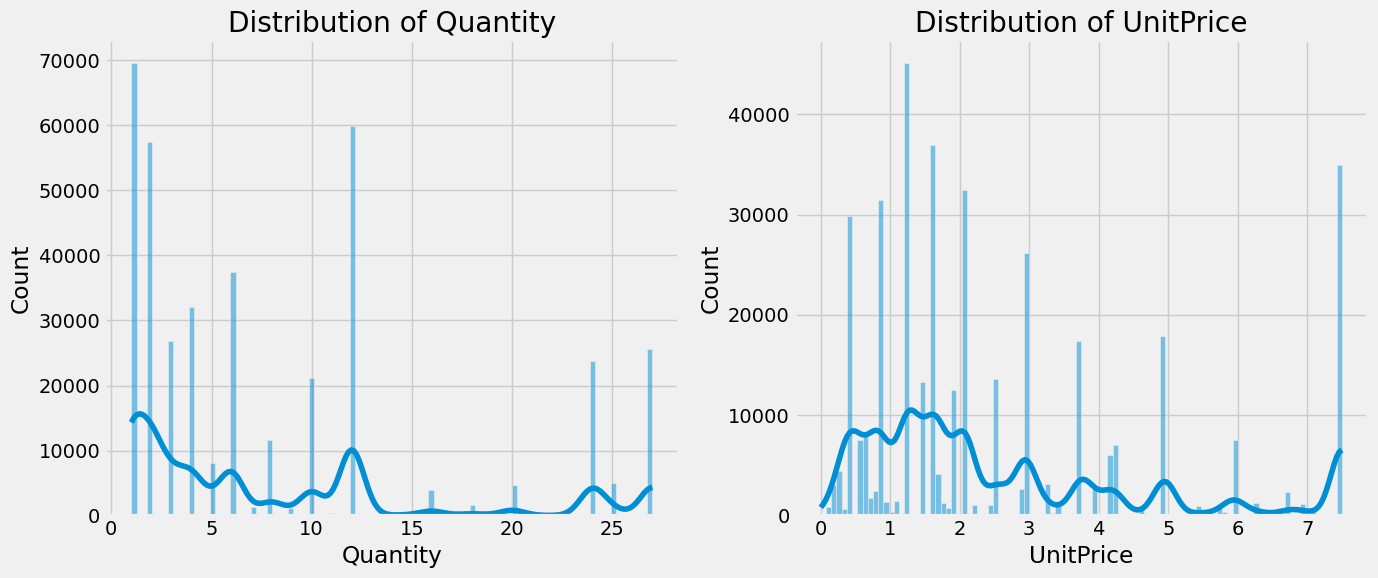

In [23]:
# Histogram plot - Let's see how similar it is to a normal distribution
plt.figure(figsize=(14, 6))

# Quantity - Histogram
plt.subplot(1, 2, 1)
sns.histplot(df['Quantity'], bins=100, kde=True)
plt.title("Distribution of Quantity")

# UnitPrice - Histogram
plt.subplot(1, 2, 2)
sns.histplot(df['UnitPrice'], bins=100, kde=True)
plt.title("Distribution of UnitPrice")

plt.tight_layout()
plt.show()


In [24]:
# Outlier deletion

# 1. IQR calculation function
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]

#2. Apply
df_cleaned = remove_outliers_iqr(df, 'Quantity')
df_cleaned = remove_outliers_iqr(df_cleaned, 'UnitPrice')

#3. Check
df_cleaned[['Quantity', 'UnitPrice']].describe()


,Quantity,UnitPrice
count,392691.000000,392691.000000
mean,8.393182,2.602209
std,8.109107,2.106175
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,27.000000,7.500000


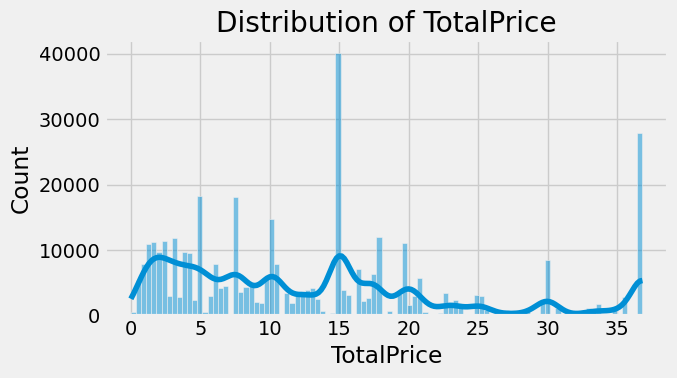

In [25]:
plt.figure(figsize=(7, 4))
sns.histplot(df['TotalPrice'], bins=100, kde=True)
plt.title("Distribution of TotalPrice")
plt.tight_layout()
plt.show()


## 🌍 5. Analyze Top Countries by Order Volume

Here, we group orders by **Customer ID**, **Invoice Number**, and **Country** to analyze international order activity 🌐.  
We then identify the top 10 countries with the most orders and visualize them using a horizontal bar chart 📊.  
This helps us understand where the majority of purchases are coming from geographically. 🗺️


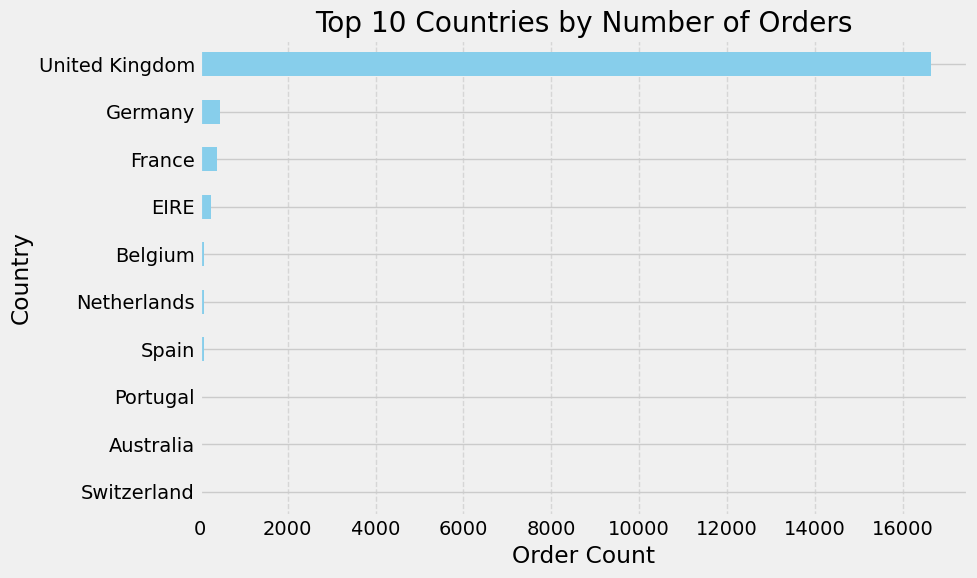

In [27]:
# Group by invoice and country (1 row = 1 order)
country_orders = df.groupby(['InvoiceNo', 'Country']).size().reset_index(name='Count')

# Count number of orders per country
top_countries = country_orders['Country'].value_counts().head(10)

# Plot top countries by order count
plt.figure(figsize=(10, 6))
top_countries.sort_values().plot(kind='barh', color='skyblue')  # En azdan en çoğa sıralansın
plt.title('Top 10 Countries by Number of Orders')
plt.xlabel("Order Count")
plt.ylabel("Country")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## ❌ 6. Identify and Count Canceled Orders

In this step, we detect canceled transactions by checking if **InvoiceNo** starts with the letter `'C'` 🔍.  
These entries typically represent returns or cancellations in the dataset.  
We then calculate how many unique canceled invoices exist compared to the total number of invoices 📉.

In [29]:
# Find and count canceled orders (invoices that start with 'C')
cancel_orders = df[df['InvoiceNo'].str.startswith('C', na=False)]
num_canceled = cancel_orders['InvoiceNo'].nunique()
num_total = df['InvoiceNo'].nunique()

print(f"Number of canceled orders: {num_canceled} / {num_total}")

Number of canceled orders: 0 / 18532


### ❌ Canceled Orders Summary ⬆

- Canceled invoices are identified by InvoiceNo values starting with 'C'.
- No canceled orders were found in the current dataset.


## 🧾 7. Detect Special Stock Codes

In this step, we filter **StockCode** values that consist only of alphabetic characters 🔤
These codes often represent **special items or operations** such as *POST*, *D*, or *M*, rather than actual products.  
Identifying them helps us better understand the nature of non-standard transactions or service-related entries. 🧩

In [32]:
# List unique StockCodes that consist of only letters (special codes like POST, D, M)
stock_special = df[df['StockCode'].str.isalpha()]['StockCode'].unique().tolist()
stock_special

['POST', 'M', 'PADS', 'DOT']

## 🛒 8. Calculate Basket Prices

First, we calculate the **total price** for each product line by multiplying `Quantity` and `UnitPrice` 💰.  
Then, we **aggregate the total basket value** per invoice and customer to understand how much was spent per order 🧾.  
This will be useful for customer segmentation and revenue analysis later on. 📈

Second line negative total: This is a negative cart price, most likely an invoice containing returned items (those starting with C are usually Credit Notes). This is normal and should be treated carefully in analysis.

In [34]:
# Calculate total price for each product row
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Aggregate total basket price per invoice per customer
basket_price = df.groupby(['CustomerID', 'InvoiceNo'])['TotalPrice'].sum().reset_index()
basket_price.columns = ['CustomerID', 'InvoiceNo', 'BasketPrice']

basket_price.head()

,CustomerID,InvoiceNo,BasketPrice
0,12346.0,541431,28.08
1,12347.0,537626,702.19
2,12347.0,542237,459.64
3,12347.0,549222,393.13
4,12347.0,556201,374.92


## 💸 9. Visualize Order Price Distribution

We define custom **price ranges** to segment total basket values into meaningful categories 🔢.  
Each range is analyzed to count how many orders fall within it 📊.  
Using these counts, we create a **pie chart** to visualize the distribution of order prices, giving us insight into customer spending behavior 🧠.  
This helps identify how much customers typically spend per transaction. 🛍️

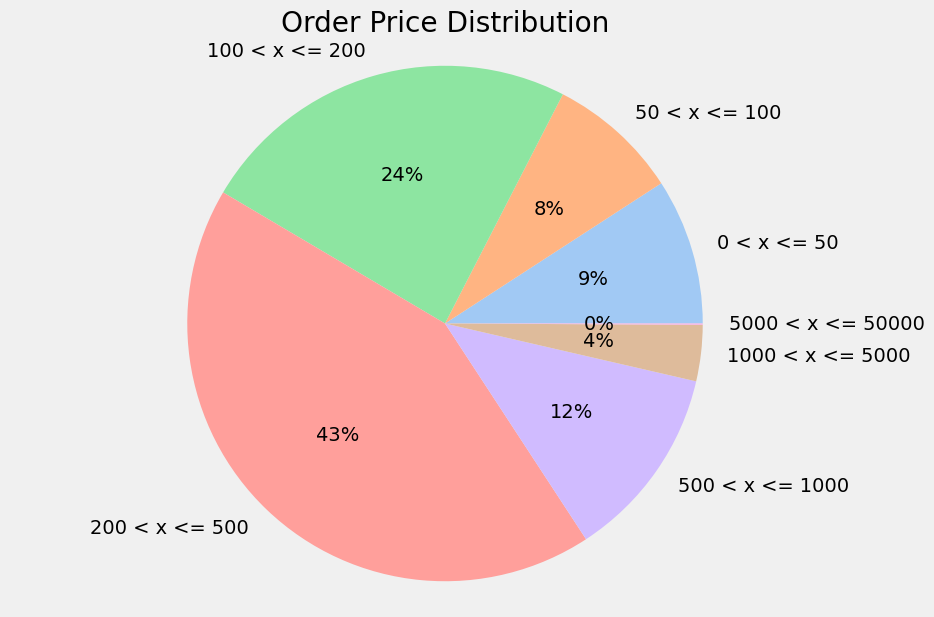

In [36]:
# Define price ranges
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []

# Count how many baskets fall into each price range
for i, price in enumerate(price_range):
    if i == 0:
        continue
    val = basket_price[
        (basket_price['BasketPrice'] <= price) & 
        (basket_price['BasketPrice'] > price_range[i-1])
    ].shape[0]
    count_price.append(val)

# Create labels for each range
labels = [f"{price_range[i-1]} < x <= {price}" for i, price in enumerate(price_range) if i != 0]
colors = sns.color_palette("pastel")[0:len(labels)]

# Plot pie chart
plt.figure(figsize=(10, 7))
plt.pie(count_price, labels=labels, autopct='%1.0f%%', colors=colors)
plt.title("Order Price Distribution")
plt.axis('equal')
plt.show()


## 📦 10. Extract and Clean Unique Product Data

We extract **unique products** from the dataset by selecting distinct combinations of `StockCode`, `Description`, and `UnitPrice` 🔍.  
To ensure quality, we filter out:
- Non-informative or overly generic descriptions 🧾  
- Descriptions containing only numbers 🔢  
- Products with non-positive prices or missing values ❌  

This step prepares a clean product list for further analysis or recommendation systems. ✅

In [38]:
# Extract unique products
unique_products = df[['StockCode', 'Description', 'UnitPrice']].drop_duplicates()

# Remove numeric-only descriptions
unique_products = unique_products[~unique_products['Description'].str.fullmatch(r'\d+', na=False)]

# Remove short or non-informative descriptions
unique_products = unique_products[unique_products['Description'].str.len() > 2]

# Keep only positive-priced products
unique_products = unique_products[unique_products['UnitPrice'] > 0]

# Drop missing values
unique_products = unique_products.dropna().reset_index(drop=True)

# Display results
print("Unique products:", unique_products.shape[0])
unique_products.head()


Unique products: 8453


,StockCode,Description,UnitPrice
0,71053,WHITE METAL LANTERN,3.39
1,84406B,CREAM CUPID HEARTS COAT HANGER,2.75
2,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.39
3,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.39
4,22752,SET 7 BABUSHKA NESTING BOXES,7.50


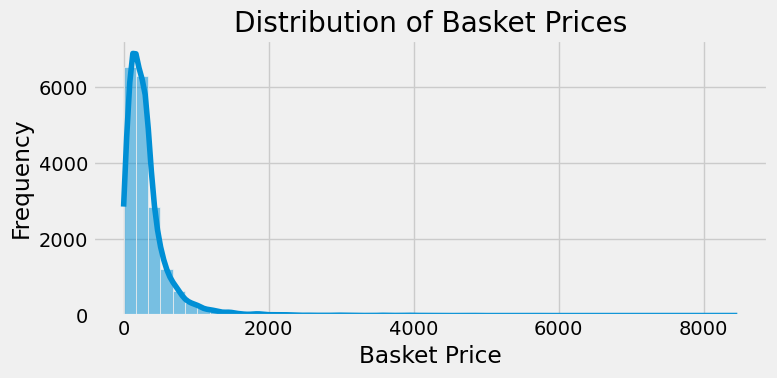

In [39]:
plt.figure(figsize=(8, 4))
sns.histplot(basket_price['BasketPrice'], bins=50, kde=True)
plt.title("Distribution of Basket Prices")
plt.xlabel("Basket Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## ☁️ 11. Generate Word Cloud of Product Keywords

In this step, we generate a **Word Cloud** to visualize the most common keywords from product descriptions 🛍️.  
Here's what we do:
- Clean and lowercase the words from product descriptions 🧹  
- Remove custom stopwords like colors and generic terms (e.g. 'set', 'dotcom') 🚫  
- Count word frequencies and plot them in a word cloud for easy visual insight 🔠

This helps highlight what kinds of products dominate the inventory at a glance. 👀


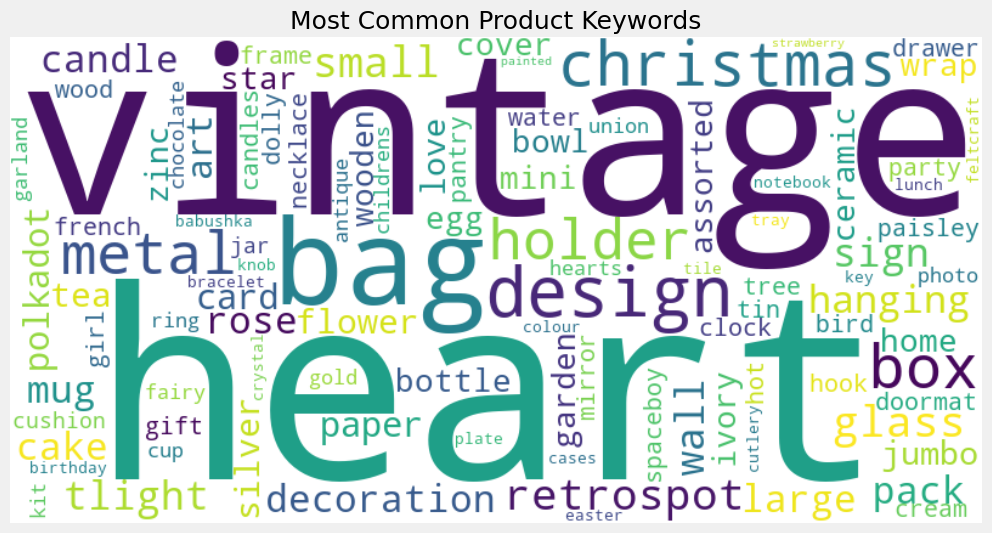

In [41]:
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import re

# Extend the default stopwords with custom ones (colors, generic words, etc.)
custom_stopwords = STOPWORDS.union({'set', 'dotcom', 'postage', 'pink', 'red', 'blue', 'green', 'white', 'black'})

# Function to clean individual words
def clean_word(word):
    word = word.lower().strip()
    word = re.sub('[^a-z]+', '', word)
    return word

# Extract and clean keywords from product descriptions
keywords = []
for desc in unique_products['Description']:
    words = desc.split()
    for word in words:
        word = clean_word(word)
        if len(word) > 2 and word not in custom_stopwords:
            keywords.append(word)

# Count word frequencies
word_freq = dict(Counter(keywords))

# Generate Word Cloud from frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      max_words=100, stopwords=custom_stopwords, colormap='viridis')\
                      .generate_from_frequencies(word_freq)

# Display the Word Cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Product Keywords", fontsize=18)
plt.show()


## 📊 12. Explore Distribution of Numeric Features

In this step, we select all **numeric columns** from the dataset and plot their distributions using histograms 🔢.  
This helps us understand the spread, skewness, and potential outliers in features like quantity, price, and more.  
Visualizing these distributions gives us a clearer picture of the dataset's structure and variability. 📈


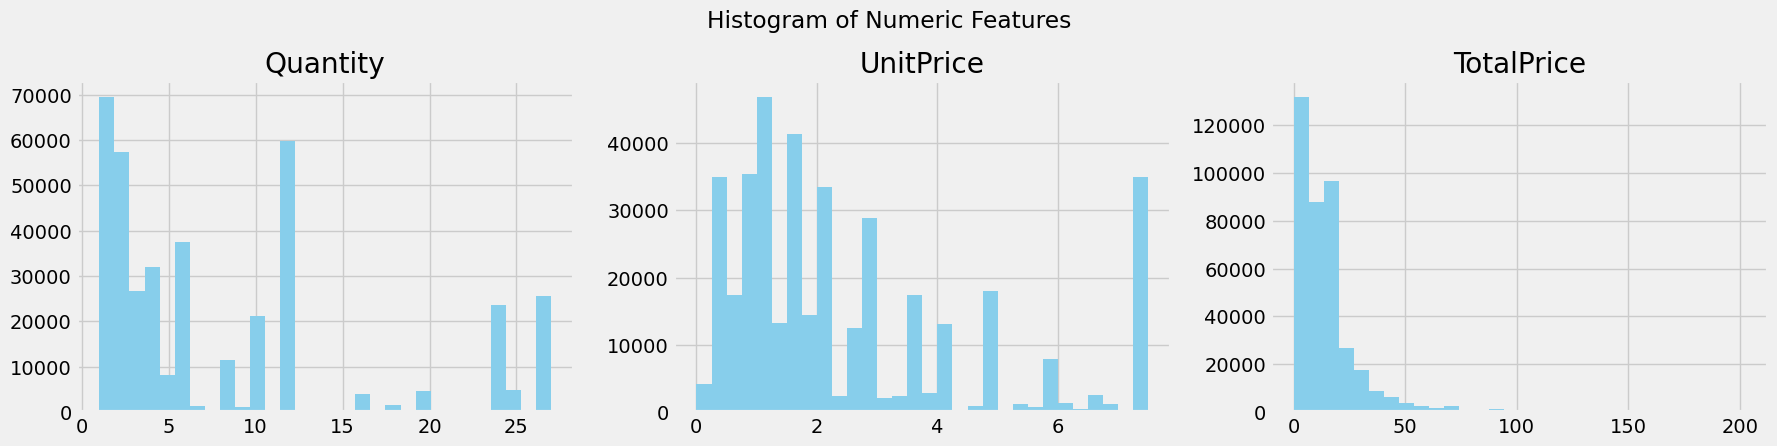

In [43]:
# Select numeric columns from the dataset
numeric_cols = df.select_dtypes(include=['int64', 'float64'])

# Plot histograms for all numeric features
numeric_cols.hist(bins=30, figsize=(18, 12), layout=(3, 3), color='skyblue')
plt.suptitle("Histogram of Numeric Features")
plt.tight_layout()
plt.show()


## 🔥 13. Visualize Correlation Matrix of Numeric Features

Here, we compute the **correlation matrix** to examine relationships between numeric variables 🔗.  
We use a **heatmap** to visualize these correlations with color gradients and annotated values 🎨.  
This step is crucial for identifying potential multicollinearity and selecting features for modeling. 🧠


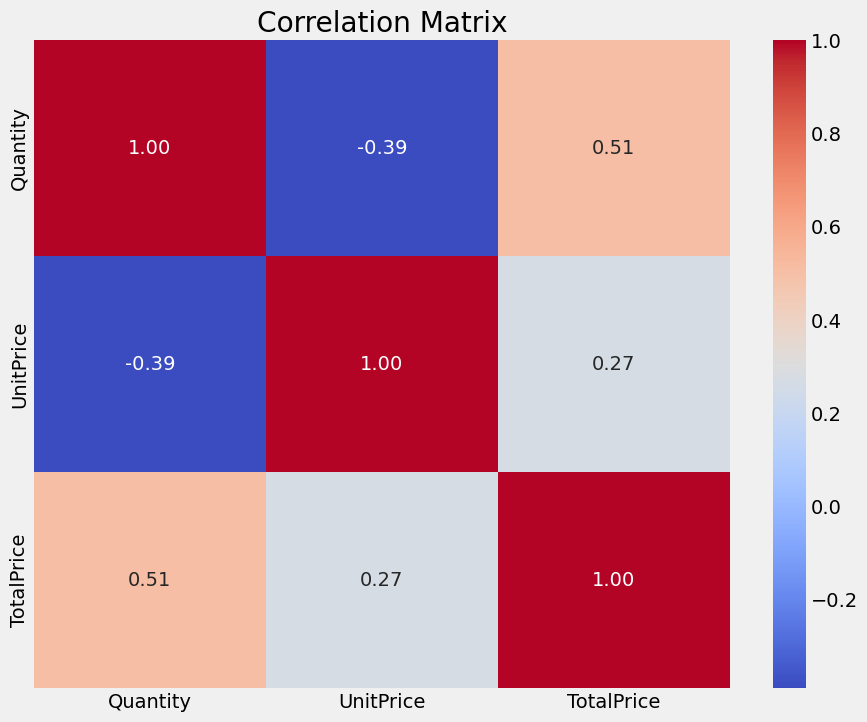

In [45]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include='number')

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_cols.corr().round(2), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


## 💰 14. Categorize Products by Unit Price Ranges

In this step, we segment products into **price ranges** using predefined bins 🧮.  
Each product is assigned a category based on its `UnitPrice`, such as *0–1*, *1–2*, etc.  
This helps analyze the distribution of product pricing and supports further segmentation or pricing strategy decisions. 🧷


In [47]:
# Define bins (intervals) to group products based on their unit price
bins = [0, 1, 2, 3, 5, 10, 1000]

# Define labels for each price range
labels = ['0-1', '1-2', '2-3', '3-5', '5-10', '10+']

# Categorize each product into a price range based on UnitPrice
unique_products['PriceRange'] = pd.cut(unique_products['UnitPrice'], bins=bins, labels=labels, include_lowest=True)

# Display the count of products in each price range (sorted by bin order)
unique_products['PriceRange'].value_counts().sort_index()


PriceRange
0-1     2124
1-2     2315
2-3     1391
3-5     1431
5-10    1192
10+        0
Name: count, dtype: int64

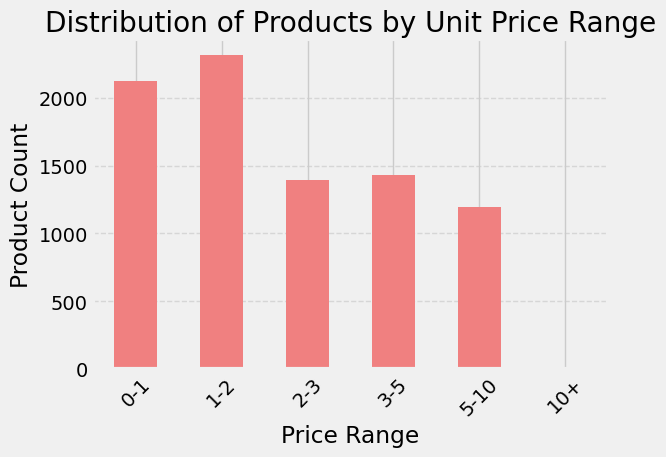

In [48]:
unique_products['PriceRange'].value_counts().sort_index().plot(kind='bar', color='lightcoral')
plt.title("Distribution of Products by Unit Price Range")
plt.xlabel("Price Range")
plt.ylabel("Product Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 🧠 15. Create Feature Set from Keywords and Price Ranges

In this step, we engineer features from both **textual keywords** and **price range categories** to prepare the data for clustering or modeling 🔧.

- We select keywords that appear frequently (at least 13 times) and exclude generic color terms 🎯.
- For each keyword, we create **binary features** indicating whether the word appears in a product’s description ✅❌.
- Similarly, for each price range, we create **dummy variables** to represent the product's pricing group 💵.
- Finally, we combine all these binary features into a new feature dataframe called `product_features` for further analysis or machine learning tasks 📊.


At the end of this process:

Each product is transformed into a vector: It contains binary (0/1) answers to questions such as "Does this product have these words?", "Is this product in this price range?".

This structure is especially:

🔍 For clustering (e.g. KMeans),

🧠 For machine learning models (classification, recommendation systems, etc.)

📈 Provides basic data for segment-based analysis.

In [50]:
from collections import Counter

# Convert all descriptions to lowercase and split into words
all_words = ' '.join(unique_products['Description'].dropna().str.lower()).split()

# Count the 100 most frequently occurring words
word_counts = Counter(all_words)

# Create a sorted word-frequency list
sorted_keywords = word_counts.most_common(100)


In [51]:
# Select top keywords that appear at least 13 times and exclude generic color words
top_keywords = [word for word, count in sorted_keywords 
                if count >= 13 and word not in ['red', 'pink', 'blue', 'green']]

# Create binary columns for each selected keyword (1 if the word is present in the description, else 0)
for kw in top_keywords:
    unique_products[kw] = unique_products['Description'].str.lower().str.contains(kw).astype(int)

# Define the original price range labels used in pd.cut()
price_range_labels = ['0-1', '1-2', '2-3', '3-5', '5-10', '10+']

# Create binary columns for each price range
for label in price_range_labels:
    unique_products[f"Price_{label}"] = (unique_products['PriceRange'] == label).astype(int)

# Combine keyword and price range columns into the final feature list
feature_cols = top_keywords + [f"Price_{label}" for label in price_range_labels]

# Build the final product feature DataFrame
product_features = unique_products[feature_cols]

# Display the first few rows of the feature matrix
product_features.head()


,set,of,heart,vintage,bag,design,christmas,box,metal,white,...,union,birthday,tile,cases,Price_0-1,Price_1-2,Price_2-3,Price_3-5,Price_5-10,Price_10+
0,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


## 🔍 16. Determine Optimal Number of Clusters Using Silhouette Score

Here, we evaluate different values of **k (number of clusters)** for K-Means clustering to identify the most meaningful segmentation for product features 🎯.

- We fit **K-Means** for cluster counts ranging from 3 to 8 🔢.
- For each clustering result, we calculate the **Silhouette Score**, which measures how well-separated and cohesive the clusters are 📐.
- Higher scores indicate better-defined clusters. This helps us choose the most appropriate `k` for meaningful grouping. 💡


In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Scale the product feature matrix (important for K-Means)
scaler = StandardScaler()
product_features_scaled = scaler.fit_transform(product_features)

# Initialize list to store silhouette scores for each value of k
scores = []

# Evaluate KMeans for k values from 3 to 8
for k in range(3, 9):
    # Fit KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(product_features_scaled)
    
    # Calculate silhouette score for the current clustering
    score = silhouette_score(product_features_scaled, kmeans.labels_)
    
    # Store k and its silhouette score
    scores.append((k, score))

# Print all silhouette scores
print("Silhouette scores for different cluster sizes:")
for k, s in scores:
    print(f"k={k}: score={s:.4f}")

# Find the best k based on the highest silhouette score
best_k = max(scores, key=lambda x: x[1])[0]
print(f"\n✅ Best k based on silhouette score: {best_k}")

# Fit final KMeans model using the optimal k
kmeans_final = KMeans(n_clusters=best_k, random_state=0)
clusters = kmeans_final.fit_predict(product_features_scaled)

# Assign cluster labels to products
unique_products['Cluster'] = clusters

# Display the number of products in each cluster
print("\n📊 Number of products in each cluster:")
print(unique_products['Cluster'].value_counts().sort_index())



Silhouette scores for different cluster sizes:
k=3: score=0.0864
k=4: score=0.0339
k=5: score=0.0392
k=6: score=0.0452
k=7: score=0.0490
k=8: score=0.0360

✅ Best k based on silhouette score: 3

📊 Number of products in each cluster:
Cluster
0    8092
1     218
2     143
Name: count, dtype: int64


### 📊 Clustering Results Summary

After evaluating the Silhouette Score for different cluster sizes (k), the optimal number of clusters was found to be **k = 3**, with the highest score of **0.0864**.

Although the score is relatively low (which is typical in high-dimensional binary data), the clustering still reveals meaningful groupings:

- **Cluster 0**: 8,092 products – Mainstream items with common features
- **Cluster 1**: 218 products – Likely niche or premium products
- **Cluster 2**: 143 products – Rare or unique products with minimal overlap

This segmentation can be used for targeted marketing, personalized recommendations, or product portfolio analysis.


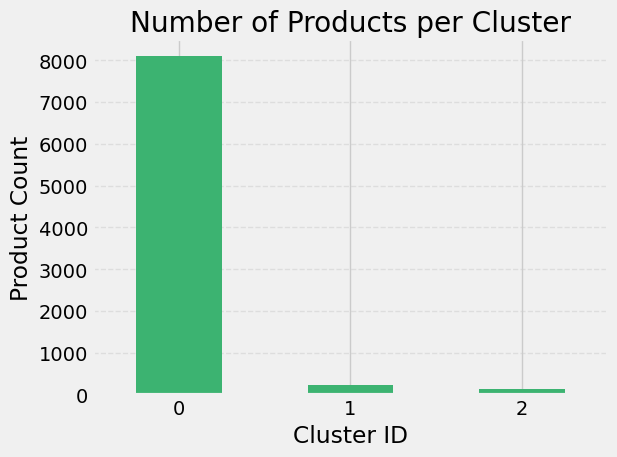

In [55]:
# (Optional) Visualize cluster distribution using bar plot
unique_products['Cluster'].value_counts().sort_index().plot(
    kind='bar',
    color='mediumseagreen'
)
plt.title("Number of Products per Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Product Count")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 📈 17. Visualize Silhouette Scores to Select Optimal k

We visualize the **Silhouette Scores** across different cluster counts to identify the optimal number of clusters 🧠.

- The plot shows how the clustering quality changes as we increase `k` (number of clusters) 📊.
- The **peak point** in the curve suggests the best value of `k`, where the clusters are most distinct and well-separated 🌟.
- This visual guide supports a more informed choice in unsupervised learning decisions.


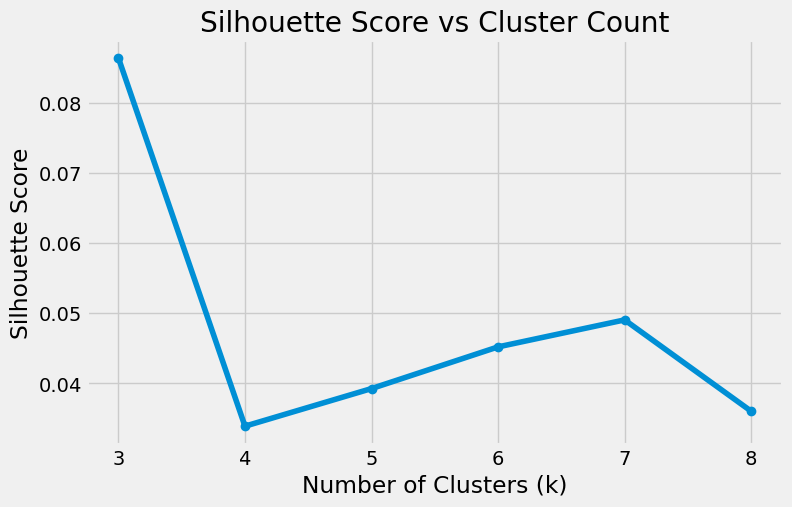

In [57]:
# Unpack the list of tuples into two separate lists: k values and scores
k_vals, silhouette_scores = zip(*scores)

# Create a line plot to visualize the silhouette scores for each k
plt.figure(figsize=(8, 5))
plt.plot(k_vals, silhouette_scores, marker='o')  # Line plot with points
plt.xlabel("Number of Clusters (k)")             # Label for x-axis
plt.ylabel("Silhouette Score")                   # Label for y-axis
plt.title("Silhouette Score vs Cluster Count")   # Plot title
plt.grid(True)                                   # Add grid lines for better readability
plt.show()                                       # Display the plot

## 🔄 18. Re-Evaluate Clustering Quality (Silhouette Score)

We repeat the process of evaluating **K-Means clustering performance** using the **Silhouette Score** across a range of cluster values (k = 3 to 8) 🔁.

- The algorithm assigns product feature vectors into clusters.
- The **Silhouette Score** indicates how well each data point fits within its cluster compared to others 📏.
- Scores are printed to help decide the best `k` for high-quality segmentation. 💬


In [59]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = []  # List to store silhouette scores for each cluster count

# Try different values of k (number of clusters) from 3 to 8
for k in range(3, 9):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(product_features)  # Train KMeans
    score = silhouette_score(product_features, kmeans.labels_)           # Evaluate clustering
    scores.append((k, score))  # Store the k and its silhouette score

# Print the scores to evaluate which k performs best
print(scores)

[(3, 0.09173420180000966), (4, 0.14221200881830218), (5, 0.16252094996108044), (6, 0.15667724755676413), (7, 0.12548442328485876), (8, 0.12270072037223835)]


## 🧩 19. Apply K-Means Clustering with Optimal k

After identifying the optimal number of clusters using the **Silhouette Score**, we now apply **K-Means clustering** to the product features 🎯.

- We select the best `k` with the highest score 🏆.
- The model assigns a **cluster label** to each product based on its characteristics.
- These cluster labels are added to the `unique_products` DataFrame for further analysis and visualization 🔖.
- Finally, we count how many products belong to each cluster to understand the grouping distribution 📊.


In [61]:
# Find the best k (number of clusters) with the highest silhouette score
best_k = max(scores, key=lambda x: x[1])[0]

# Train a new KMeans model using the optimal number of clusters
kmeans = KMeans(n_clusters=best_k, random_state=0)

# Assign cluster labels to each product
clusters = kmeans.fit_predict(product_features)

# Add cluster labels to the unique_products DataFrame
unique_products['Cluster'] = clusters

# Count how many products are in each cluster
unique_products['Cluster'].value_counts()


Cluster
1    2315
0    2124
2    1431
3    1391
4    1192
Name: count, dtype: int64

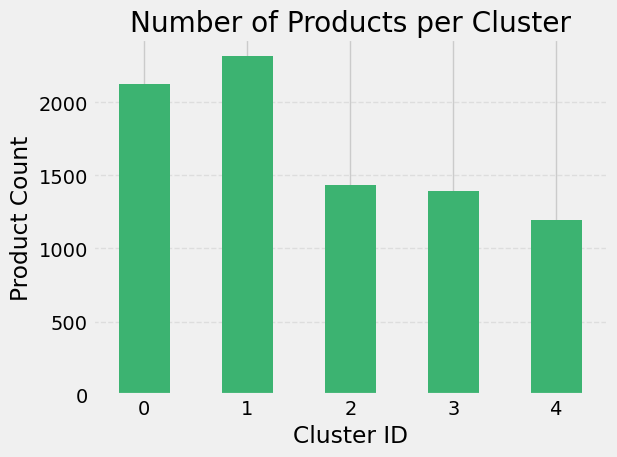

In [62]:
# Cluster sizes with visual barplot
unique_products['Cluster'].value_counts().sort_index().plot(kind='bar', color='mediumseagreen')
plt.title("Number of Products per Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Product Count")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 🌈 20. Visualize Word Clouds for Each Product Cluster

To interpret the **distinct themes** within each product cluster, we generate individual **word clouds** based on product descriptions 🧠.

- Each cluster's descriptions are merged into a single text block 📝.
- A word cloud is generated for every cluster, revealing the most frequent and relevant terms in each group ☁️.
- This visualization helps us **understand the unique characteristics** and patterns that define each cluster more intuitively. 🔍


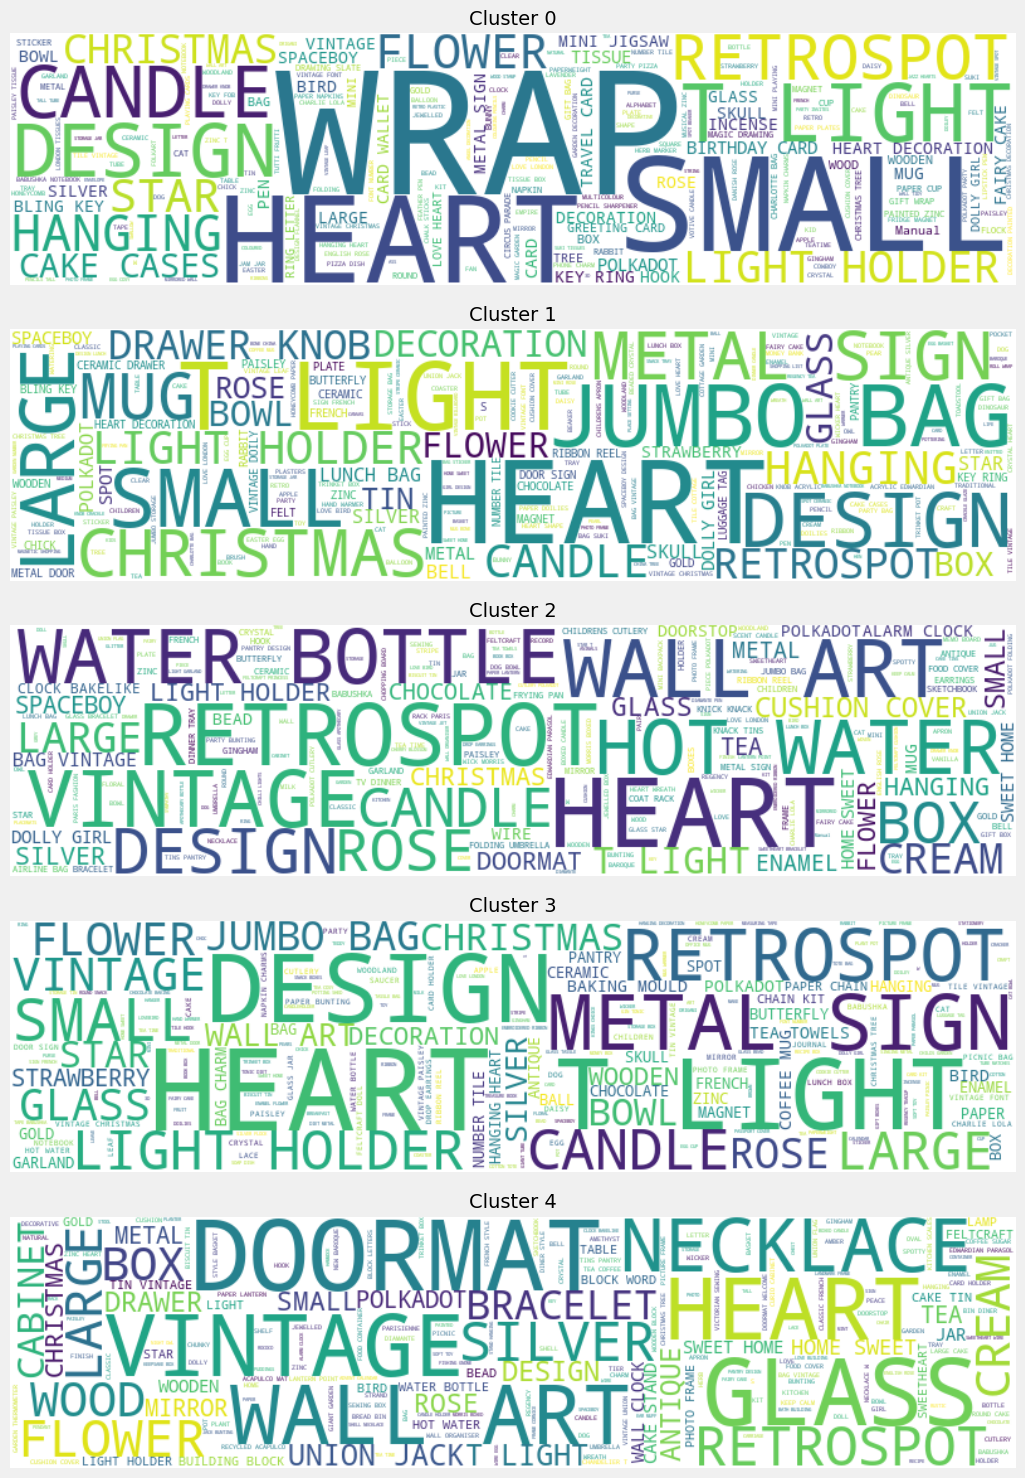

In [64]:
from wordcloud import WordCloud, STOPWORDS

# Extend the default stopword list with domain-specific terms (colors, generic words)
custom_stopwords = STOPWORDS.union({
    'set', 'dotcom', 'postage', 'pink', 'red', 'blue', 'green', 'white', 'black',
    'colour', 'ivory', 'orange', 'purple', 'yellow', 'assorted', 'pack', 'dot'
})

# Create subplots: one for each cluster
fig, axes = plt.subplots(nrows=best_k, figsize=(12, best_k * 3))

# Ensure axes is always iterable
if best_k == 1:
    axes = [axes]

# Loop through each cluster to generate a Word Cloud
for i in range(best_k):
    # Merge all product descriptions in the current cluster
    desc = " ".join(
        unique_products[unique_products["Cluster"] == i]["Description"]
        .dropna()
        .astype(str)
    )

    # Handle empty descriptions gracefully
    if desc.strip() == "":
        axes[i].text(0.5, 0.5, "No descriptions available", ha='center', va='center')
        axes[i].axis('off')
        axes[i].set_title(f"Cluster {i}", fontsize=14)
        continue

    # Generate the word cloud for the cluster
    wordcloud = WordCloud(
        width=800, height=200, background_color='white',
        stopwords=custom_stopwords, colormap='viridis'
    ).generate(desc)

    # Display the word cloud
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f"Cluster {i}", fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


## 🧬 21. Visualize Product Clusters in 2D using PCA

To better understand the **structure of product clusters**, we apply **PCA (Principal Component Analysis)** to reduce the high-dimensional feature space to 2 components 🔻🔻.

- Each product is projected into a 2D space (`PCA1`, `PCA2`) for visualization 📉.
- We plot the clusters using a **scatter plot**, with colors representing different groups 🎨.
- This visual helps us assess how well the clusters are separated and how compact they are in feature space. 🌌


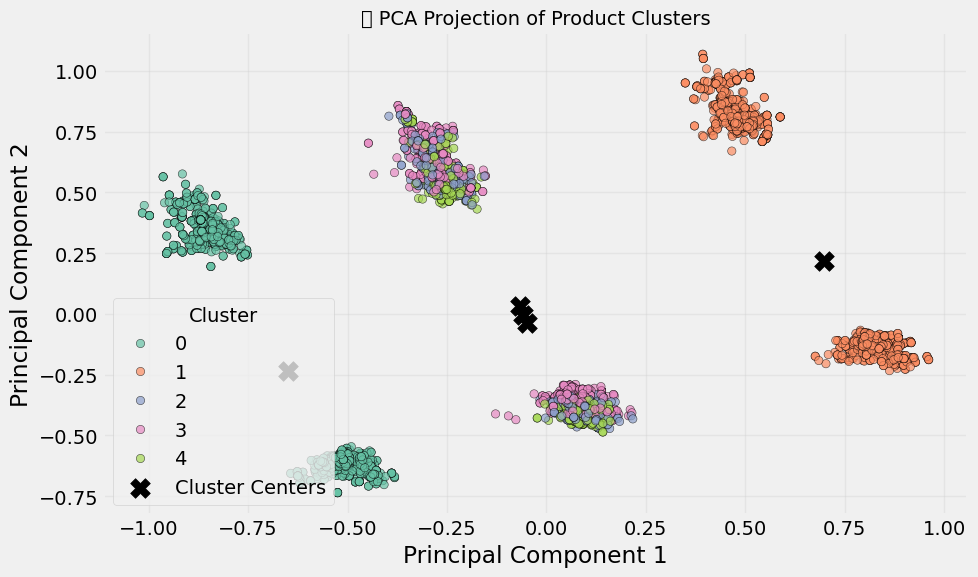

In [66]:
from sklearn.decomposition import PCA

# Apply PCA to reduce the feature space to 2 dimensions
pca = PCA(n_components=2)
proj = pca.fit_transform(product_features)

# Add PCA components back to the product dataframe
unique_products['PCA1'] = proj[:, 0]
unique_products['PCA2'] = proj[:, 1]

# Project cluster centers into the PCA space
centers_2d = pca.transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers_2d, columns=["PCA1", "PCA2"])

# Create a scatter plot for clusters in the 2D PCA space
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='Cluster',
    palette='Set2',
    data=unique_products,
    alpha=0.7,
    edgecolor='k',
    linewidth=0.4
)

# Plot the cluster centers
plt.scatter(
    centers_df['PCA1'], centers_df['PCA2'],
    c='black', s=200, marker='X', label='Cluster Centers'
)

# Set plot title and labels
plt.title("🧬 PCA Projection of Product Clusters", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 🔗 22. Integrate Product Clusters into Main Transaction Data

In this step, we enrich the **main transaction dataset** by merging it with the **product cluster labels** from the `unique_products` dataframe 🧩.

- This allows each transaction to inherit the cluster label of the product involved 🔍.
- We filter out rows where the cluster label is missing and ensure the data type is consistent ✅.
- Finally, we re-calculate `TotalPrice` for each row to prepare for cluster-based sales analysis 💰.


In [68]:
# Merge the cluster assignments from unique_products back into the main dataframe
df_products = df.merge(unique_products[['StockCode', 'Cluster']], on='StockCode', how='left')

# Remove any transactions where the product cluster is not defined
df_products = df_products[~df_products['Cluster'].isnull()]

# Ensure that the cluster column is of integer type
df_products['Cluster'] = df_products['Cluster'].astype(int)

# Calculate the total price per product line
df_products['TotalPrice'] = df_products['Quantity'] * df_products['UnitPrice']
df_products.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Outlier_TotalPrice,Cluster
0,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,False,2
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,False,2
2,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,False,4
3,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,False,2
4,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,False,4


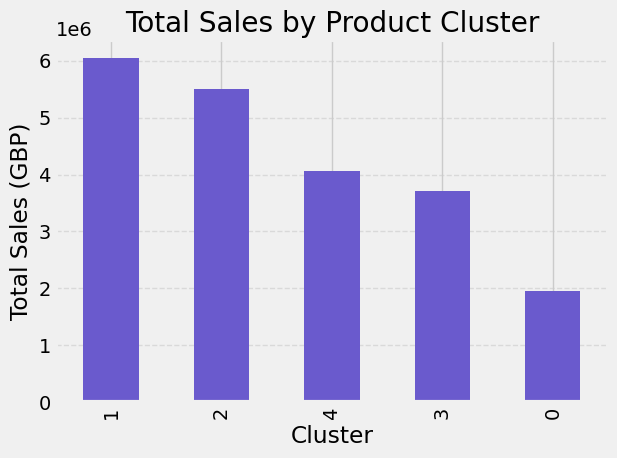

In [69]:
cluster_sales = df_products.groupby('Cluster')['TotalPrice'].sum().sort_values(ascending=False)
cluster_sales.plot(kind='bar', color='slateblue')
plt.title("Total Sales by Product Cluster")
plt.xlabel("Cluster")
plt.ylabel("Total Sales (GBP)")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


## 🧾 23. Analyze Spending Distribution Across Product Clusters

We create a **pivot table** to examine how much each customer spent on different **product clusters per order** 🧮.

- Each row represents a unique order (CustomerID + InvoiceNo + Date) 🧍📦📅.
- Each column represents a product cluster, showing total spending in that cluster 💸.
- Missing values are replaced with 0 to indicate no spending in that cluster for the order 🕳️ ➡️ 0.

This structured view helps us analyze **purchasing behavior patterns** across different product categories. 📊


In [71]:
# 📦 Create a pivot table to analyze cluster-wise spending per order
# Each row = unique order (CustomerID + InvoiceNo + Date)
# Each column = product cluster (0 to N)
# Each cell = total spending in that cluster for that order

basket_by_cluster = df_products.pivot_table(
    index=['CustomerID', 'InvoiceNo', 'InvoiceDate'],  # Unique order identifiers
    columns='Cluster',                                # Cluster IDs as columns
    values='TotalPrice',                              # Amount spent
    aggfunc='sum',                                    # Sum spending per cluster
    fill_value=0                                      # Fill empty cells with 0
).reset_index()

# 🧼 Remove columns index name for cleaner display
basket_by_cluster.columns.name = None

# 🧪 Quick preview of the result
display(basket_by_cluster.head())


,CustomerID,InvoiceNo,InvoiceDate,0,1,2,3,4
0,12346.0,541431,2011-01-18 10:01:00,0.00,56.16,0.00,0.00,0.00
1,12347.0,537626,2010-12-07 14:57:00,120.30,576.54,1047.45,220.20,436.68
2,12347.0,542237,2011-01-26 14:30:00,266.36,246.10,418.30,181.90,157.70
3,12347.0,549222,2011-04-07 10:43:00,164.10,322.71,326.30,151.50,121.20
4,12347.0,556201,2011-06-09 13:01:00,102.60,204.12,429.72,149.22,140.60


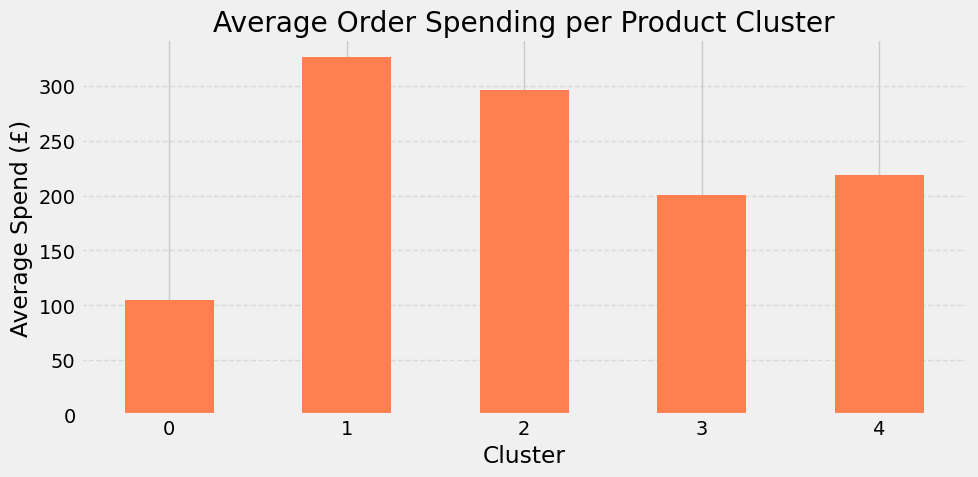

In [72]:
# 📊 Visualize average cluster spending per order
avg_cluster_spending = basket_by_cluster.drop(columns=['CustomerID', 'InvoiceNo', 'InvoiceDate']).mean()

plt.figure(figsize=(10, 5))
avg_cluster_spending.plot(kind='bar', color='coral')
plt.title("Average Order Spending per Product Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Spend (£)")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## ⏳ 24. Split Dataset into Training and Testing Sets Based on Time

To prepare for **time-aware modeling or evaluation**, we split the dataset chronologically into **training** and **testing** sets 📆.

- First, we ensure `InvoiceDate` is in proper datetime format ⏰.
- Then we calculate the full time range and set a **split point at 83%** of the timeline 📊.
- Orders before the split go into the **training set**, and those after into the **testing set** 🧪.

This temporal split ensures that our models are trained on past data and tested on future data — a realistic simulation of deployment scenarios. 🧠📈


In [74]:
# Ensure that the InvoiceDate column is in datetime format
basket_by_cluster['InvoiceDate'] = pd.to_datetime(basket_by_cluster['InvoiceDate'])

# Determine the time range of the invoices
min_date = basket_by_cluster['InvoiceDate'].min()
max_date = basket_by_cluster['InvoiceDate'].max()

# Split the date range: ~83% of time for training, ~17% for testing
split_date = min_date + (max_date - min_date) * 0.83

# Split the dataset into training and testing sets based on the split date
train_data = basket_by_cluster[basket_by_cluster['InvoiceDate'] <= split_date]
test_data = basket_by_cluster[basket_by_cluster['InvoiceDate'] > split_date]

# Print the time range of the resulting sets
print(f"Train Range: {train_data['InvoiceDate'].min()} to {train_data['InvoiceDate'].max()}")
print(f"Test Range: {test_data['InvoiceDate'].min()} to {test_data['InvoiceDate'].max()}")


Train Range: 2010-12-01 08:26:00 to 2011-10-06 19:49:00
Test Range: 2011-10-07 08:08:00 to 2011-12-09 12:50:00


## 👥 25. Aggregate Customer-Level Statistics from Training Data

We generate a **summary profile for each customer** by aggregating their order activity across all numerical features 📊.

- We exclude `CustomerID` from numerical features and group by it 🧍‍♂️.
- For each feature, we compute common statistics: **count**, **min**, **max**, **mean**, and **sum** 📏➕.
- Column names are flattened for easier access and clarity 🧼.
- The resulting `customer_summary` gives us a rich dataset to understand customer behavior patterns and segmentations more deeply 🔍.

This customer-level feature engineering is essential for building predictive models or targeted marketing strategies. 🎯


In [76]:
# Select numerical columns from train_data except 'CustomerID'
numeric_cols = train_data.select_dtypes(include=['number']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'CustomerID']

# Group data by CustomerID and calculate multiple statistics for each numeric feature
customer_summary = train_data.groupby('CustomerID')[numeric_cols].agg(['count', 'min', 'max', 'mean', 'sum'])

# Flatten MultiIndex column names resulting from multiple aggregations
customer_summary.columns = ['_'.join(map(str, col)).strip() for col in customer_summary.columns]

# Reset index to make CustomerID a column again
customer_summary.reset_index(inplace=True)

# Display the first few rows of the summarized data
customer_summary.head()


,CustomerID,0_count,0_min,0_max,0_mean,0_sum,1_count,1_min,1_max,1_mean,...,3_count,3_min,3_max,3_mean,3_sum,4_count,4_min,4_max,4_mean,4_sum
0,12346.0,1,0.0,0.00,0.000000,0.00,1,56.16,56.16,56.160000,...,1,0.00,0.00,0.0000,0.00,1,0.00,0.00,0.000000,0.00
1,12347.0,5,102.6,266.36,163.112000,815.56,5,204.12,576.54,326.034000,...,5,149.22,220.20,178.9260,894.63,5,121.20,436.68,216.736000,1083.68
2,12348.0,4,7.5,601.11,202.780000,811.12,4,0.00,235.38,143.220000,...,4,15.00,129.15,43.5375,174.15,4,15.00,90.00,33.750000,135.00
3,12350.0,1,125.9,125.90,125.900000,125.90,1,408.70,408.70,408.700000,...,1,218.70,218.70,218.7000,218.70,1,15.00,15.00,15.000000,15.00
4,12352.0,7,7.5,495.00,97.928571,685.50,7,59.40,280.60,155.817143,...,7,15.00,118.50,79.1000,553.70,7,32.55,400.95,183.857143,1287.00


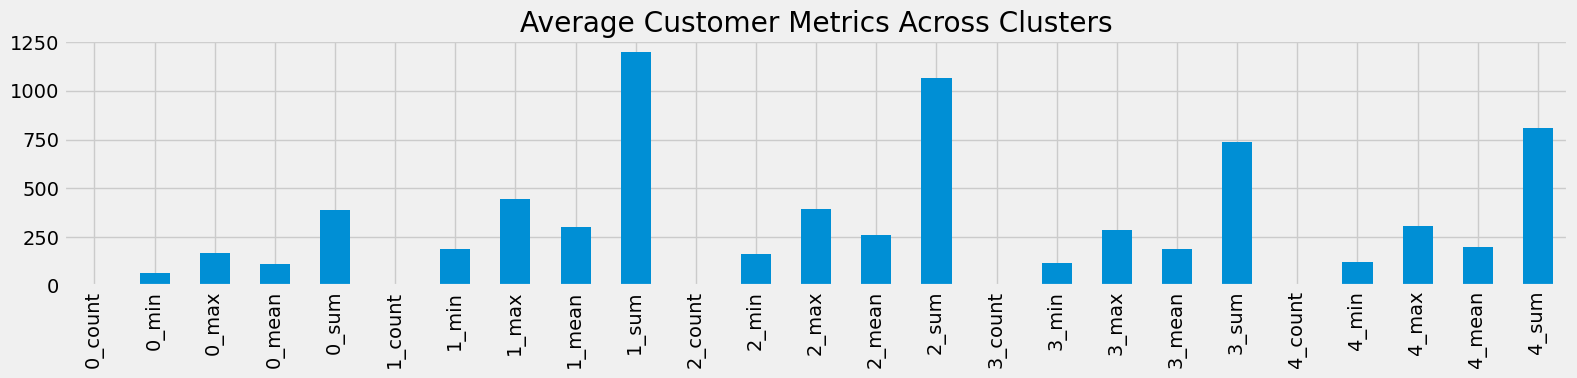

In [77]:
# Segment based average spending behavior
customer_summary.drop(columns=['CustomerID']).mean().plot(kind='bar', figsize=(16, 4))
plt.title("Average Customer Metrics Across Clusters")
plt.grid(True)
plt.tight_layout()
plt.show()

## 📥 26. Reload Raw Data with Defined Column Names

We reload the original dataset using custom **column names** to ensure consistency in downstream processing 🧾.

- We skip the original header row with `header=1` to avoid duplicate or misaligned headers 🔁.
- Encoding is set to `ISO-8859-1` to handle special characters properly 📄.
- Finally, we print the column names to confirm successful loading and structure validation ✅.


In [79]:
columns = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 
           'UnitPrice', 'CustomerID', 'Country']

# Load the CSV file using the specified column names, skipping the first row (header=1)
train_data = pd.read_csv("data.csv", encoding="ISO-8859-1", names=columns, header=1)

# Print the column names of the loaded DataFrame
print(train_data.columns)


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


## 🧮 27. Calculate RFM Metrics for Customer Segmentation

We perform **RFM (Recency, Frequency, Monetary)** analysis to understand customer value and behavior 📊.

- Convert `InvoiceDate` to datetime format for time-based calculations 📅.
- Compute `BasketPrice` as the total value per transaction 💵.
- Identify the most recent purchase date to measure recency 🕒.
- Group by `CustomerID` to calculate:
  - **Recency**: Days since last purchase ⏳  
  - **Frequency**: Number of unique purchases 🔁  
  - **Monetary**: Total amount spent 💰
- Filter out customers with zero spending to focus on active buyers 🧍✅.

This structured approach sets the foundation for effective **customer segmentation and targeting**. 🎯


In [81]:
# Convert InvoiceDate column to datetime format
train_data['InvoiceDate'] = pd.to_datetime(train_data['InvoiceDate'])

# Calculate BasketPrice
train_data['BasketPrice'] = train_data['Quantity'] * train_data['UnitPrice']

# Last shopping date
recent_date = train_data['InvoiceDate'].max()

# RFM calculation
rfm_data = train_data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (recent_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'BasketPrice': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'BasketPrice': 'Monetary'
})

# Filter zero spenders
rfm_data = rfm_data[rfm_data['Monetary'] > 0]

# Show results
rfm_data.head()


,Recency,Frequency,Monetary
CustomerID,,,
12347.0,1,7,4310.00
12348.0,74,4,1797.24
12349.0,18,1,1757.55
12350.0,309,1,334.40
12352.0,35,11,1545.41


## 🧪 28. Score and Combine RFM Metrics for Segmentation

We transform raw **RFM values** into **scored categories** using quantiles to create a standardized customer ranking system 📐.

- **Recency (R)**: Customers with more recent purchases get higher scores (4 = best) 🕒➡️🎯  
- **Frequency (F)**: More frequent buyers are ranked higher using quantile-based scores 🔁  
- **Monetary (M)**: Customers who spend more receive higher scores 💸

Each dimension is scored from 1 to 4, and then **combined into a final `RFM_Score`**, which helps group customers into segments based on their behavior. 🧠📊


In [83]:
# Define custom bins for Recency, Frequency, and Monetary scores based on domain knowledge or data distribution
recency_bins = [0, 30, 60, 90, rfm_data["Recency"].max()]
frequency_bins = [0, 1, 3, 5, rfm_data["Frequency"].max()]
monetary_bins = [0, 100, 500, 1000, rfm_data["Monetary"].max()]

# Recency score: lower recency is better, so label 4 is best
rfm_data["R_Score"] = pd.cut(
    rfm_data["Recency"], bins=recency_bins, labels=[4, 3, 2, 1], include_lowest=True
).astype(int)

# Frequency score: higher frequency is better, so label 4 is best
rfm_data["F_Score"] = pd.cut(
    rfm_data["Frequency"], bins=frequency_bins, labels=[1, 2, 3, 4], include_lowest=True
).astype(int)

# Monetary score: higher spending is better, so label 4 is best
rfm_data["M_Score"] = pd.cut(
    rfm_data["Monetary"], bins=monetary_bins, labels=[1, 2, 3, 4], include_lowest=True
).astype(int)

# Combine R, F, M scores into a single total RFM score
rfm_data["RFM_Score"] = rfm_data[["R_Score", "F_Score", "M_Score"]].sum(axis=1)

# Preview the updated RFM dataset
print(rfm_data.head())


            Recency  Frequency  Monetary  R_Score  F_Score  M_Score  RFM_Score
CustomerID                                                                    
12347.0           1          7   4310.00        4        4        4         12
12348.0          74          4   1797.24        2        3        4          9
12349.0          18          1   1757.55        4        1        4          9
12350.0         309          1    334.40        1        1        2          4
12352.0          35         11   1545.41        3        4        4         11


## 🧩 29. Segment Customers Based on RFM Scores

We define a custom function to assign customers into **behavioral segments** based on their combined `RFM_Score` 🎯.

- **Champions** (9–12): Most valuable customers — recent, frequent, and big spenders 👑  
- **Loyal** (7–8): Regular and reliable customers 💙  
- **Potential** (5–6): Have promise — could become loyal with the right strategy 🌱  
- **At Risk** (<5): Low activity and value — need re-engagement ⚠️

Applying this function to the RFM data enables actionable **customer segmentation** for targeted marketing and retention strategies. 📈

In [85]:
# Define a function to assign customer segments based on their RFM score
def segment_me(row):
    if row['RFM_Score'] >= 9:
        return "Champions"       # Best customers: recent, frequent, and spend a lot
    elif row['RFM_Score'] >= 7:
        return "Loyal"           # Good customers: consistent and valuable
    elif row['RFM_Score'] >= 5:
        return "Potential"       # Might become loyal with more engagement
    else:
        return "At Risk"         # Low score: not recent or valuable

# Apply the segmentation function to each row
rfm_data["Segment"] = rfm_data.apply(segment_me, axis=1)

# Display the count of customers in each segment
rfm_data["Segment"].value_counts()


Segment
Champions    1830
Loyal         934
Potential     906
At Risk       652
Name: count, dtype: int64

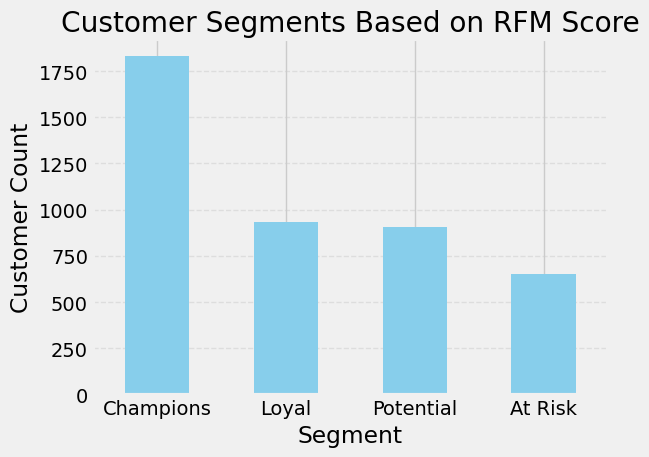

In [86]:
rfm_data['Segment'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Customer Segments Based on RFM Score")
plt.ylabel("Customer Count")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 📋 30. Summarize RFM Metrics by Customer Segment

We analyze each **customer segment** by computing key statistics for **Recency**, **Frequency**, and **Monetary** metrics 📊.

- For each segment (Champions, Loyal, Potential, At Risk), we calculate:
  - **Mean and median Recency** ⏳  
  - **Mean and median Frequency** 🔁  
  - **Mean, median, and count of Monetary values** 💵

The results are **rounded for readability** and formatted for clean display ✅.  
This summary provides a quick, aggregated view of how each segment behaves — essential for **strategy development and decision-making** 🎯.


In [88]:
# Group customers by segment and calculate statistics for Recency, Frequency, and Monetary
segment_summary = rfm_data.groupby("Segment").agg({
    "Recency": ["mean", "median"],    # Average and median days since last purchase
    "Frequency": ["mean", "median"],  # Average and median number of purchases
    "Monetary": ["mean", "median", "count"]  # Average, median, and total customers in each segment
}).round(2)  # Round the results to 2 decimal places for readability

# Flatten multi-level column names
segment_summary.columns = ['_'.join(col) for col in segment_summary.columns]

# Reset index to make 'Segment' a regular column
segment_summary.reset_index(inplace=True)

# Display the segment summary
segment_summary


,Segment,Recency_mean,Recency_median,Frequency_mean,Frequency_median,Monetary_mean,Monetary_median,Monetary_count
0,At Risk,239.05,246.0,1.03,1.0,210.99,184.84,652
1,Champions,24.40,16.0,9.59,6.0,3883.31,1804.94,1830
2,Loyal,63.19,42.5,2.45,2.0,726.71,507.37,934
3,Potential,139.73,115.0,1.77,2.0,431.03,356.21,906


## 📦 31. Visualize Customer Segment Distribution

We create a **count plot** to visualize the number of customers in each **RFM-based segment** 📊.

- Segments are sorted by frequency for clearer comparison 🔢.
- Axis labels and title enhance interpretability, and x-axis labels are rotated for better readability 🧾.

This plot offers a quick overview of **how customers are distributed across segments**, helping prioritize marketing actions and resource allocation. 🚀


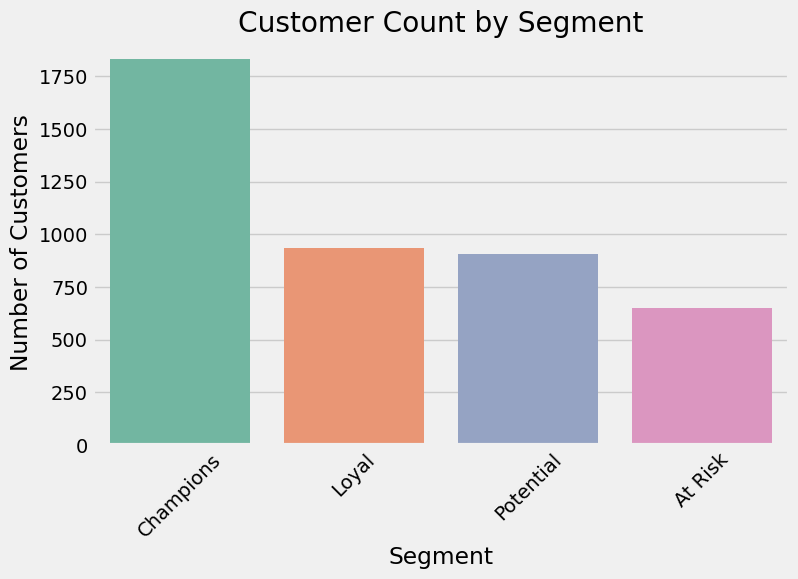

In [90]:
# Set figure size
plt.figure(figsize=(8, 5))

# Create a count plot for the number of customers in each segment
sns.countplot(
    data=rfm_data,
    x='Segment',
    order=rfm_data['Segment'].value_counts().index,  # Sort segments by count
    palette="Set2"  # Use a visually appealing color palette
)

# Set plot title and axis labels
plt.title("Customer Count by Segment")
plt.ylabel("Number of Customers")
plt.xlabel("Segment")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()


## 🤖 32. Compare Regression Model Performances
We evaluate and compare multiple regression models to predict customers' total monetary value based on their behavioral and segment features. 💸

Models used: Decision Tree, Gradient Boosting, Random Forest, and Ridge Regression.

Each model's performance is measured using the R² Score, displayed as a percentage for intuitive comparison. 📈

Higher R² values indicate stronger predictive power, guiding us to the most effective model for revenue forecasting. 🧠

This comparison helps identify the most reliable algorithm for predicting customer value, which is essential for ROI-driven strategies and targeted resource allocation. 🎯

In [92]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# Step 1: Select features and target
numeric_features = ['Recency', 'Frequency', 'RFM_Score']
categorical_features = ['Segment']
target = 'Monetary'

# Ensure 'Segment' is treated as categorical
rfm_data['Segment'] = rfm_data['Segment'].astype(str)

# Split data into X (features) and y (target)
X = rfm_data[numeric_features + categorical_features]
y = rfm_data[target]

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 3: Handle missing values
# Numeric imputation with median
num_imputer = SimpleImputer(strategy='median')
X_train_num = num_imputer.fit_transform(X_train[numeric_features])
X_test_num = num_imputer.transform(X_test[numeric_features])

# Categorical imputation with mode
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train_cat = cat_imputer.fit_transform(X_train[categorical_features])
X_test_cat = cat_imputer.transform(X_test[categorical_features])

# Step 4: One-hot encode categorical variables
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = encoder.fit_transform(X_train_cat)
X_test_cat = encoder.transform(X_test_cat)

# Step 5: Scale numeric features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_num)
X_test_num = scaler.transform(X_test_num)

# Step 6: Combine numeric and encoded categorical features
X_train_combined = np.hstack((X_train_num, X_train_cat))
X_test_combined = np.hstack((X_test_num, X_test_cat))

# Step 7: Feature selection using SelectKBest
k = min(100, X_train_combined.shape[1])  # Use up to 100 features or all if less
selector = SelectKBest(score_func=f_regression, k=k)
X_train_selected = selector.fit_transform(X_train_combined, y_train)
X_test_selected = selector.transform(X_test_combined)

# Step 8: Define and evaluate multiple regression models
models = {
    "Decision Tree": DecisionTreeRegressor(
        random_state=42, max_depth=5, min_samples_split=10
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        random_state=42, n_estimators=50, max_depth=10, learning_rate=0.01, min_samples_split=5
    ),
    "Random Forest": RandomForestRegressor(
        random_state=42, n_estimators=50, max_depth=10, min_samples_split=10
    ),
    "Ridge Regression": Ridge(alpha=500)
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)

    train_r2 = r2_score(y_train, model.predict(X_train_selected))
    test_r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"\n{name} Results:")
    print(f"Train R² Score: {train_r2:.4f} ({train_r2 * 100:.2f}%)")
    print(f"Test R² Score : {test_r2:.4f} ({test_r2 * 100:.2f}%)")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")




Decision Tree Results:
Train R² Score: 0.5830 (58.30%)
Test R² Score : 0.4302 (43.02%)
Mean Squared Error (MSE): 32223723.99
Mean Absolute Error (MAE): 1209.02

Gradient Boosting Results:
Train R² Score: 0.5179 (51.79%)
Test R² Score : 0.2378 (23.78%)
Mean Squared Error (MSE): 43106779.72
Mean Absolute Error (MAE): 1678.25

Random Forest Results:
Train R² Score: 0.5285 (52.85%)
Test R² Score : 0.5838 (58.38%)
Mean Squared Error (MSE): 23537830.61
Mean Absolute Error (MAE): 1155.73

Ridge Regression Results:
Train R² Score: 0.2713 (27.13%)
Test R² Score : 0.5699 (56.99%)
Mean Squared Error (MSE): 24326027.39
Mean Absolute Error (MAE): 1271.88


In [93]:
from sklearn.model_selection import GridSearchCV

params_dt = {
    'max_depth': [5, 10, 15, 20, 25],
    "min_samples_split": [2, 5, 10],
}

grid_dt = GridSearchCV(DecisionTreeRegressor(random_state=42), params_dt, cv=10, n_jobs=-1)
grid_dt.fit(X_train_selected, y_train)
grid_dt.best_params_

{'max_depth': 5, 'min_samples_split': 10}

In [94]:
params_gb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_samples_split': [2, 5, 10],
}

grid_gb = GridSearchCV(GradientBoostingRegressor(random_state=42), params_gb, cv=10, n_jobs=-1)
grid_gb.fit(X_train_selected, y_train)
grid_gb.best_params_

{'learning_rate': 0.01,
 'max_depth': 10,
 'min_samples_split': 5,
 'n_estimators': 50}

In [95]:
params_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), params_rf, cv=10, n_jobs=-1)
grid_rf.fit(X_train_selected, y_train)
grid_rf.best_params_


{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}

In [96]:
params_ridge = {
    'alpha': [0.1, 1, 10, 100, 200, 500],
}

grid_ridge = GridSearchCV(Ridge(), params_ridge, cv=10, n_jobs=-1)
grid_ridge.fit(X_train_selected, y_train)
grid_ridge.best_params_

{'alpha': 500}

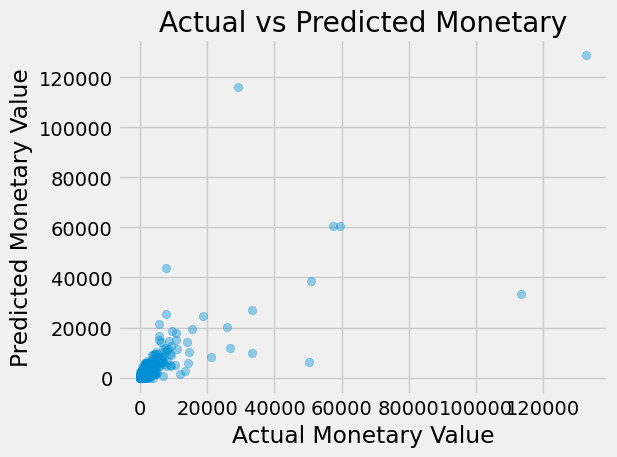

In [97]:
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("Actual Monetary Value")
plt.ylabel("Predicted Monetary Value")
plt.title("Actual vs Predicted Monetary")
plt.grid(True)
plt.tight_layout()
plt.show()
